## Evaluate Exercise (Regression Unit)
### Corey Solitaire
#### 9/31/2020

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# This is the code for the Linear Model
from statsmodels.formula.api import ols

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
from sklearn.model_selection import train_test_split
from pydataset import data

import warnings
warnings.filterwarnings('ignore')

from evaluate import linear_model
from wrangle import wrangle_telco

*****

# Evaluating simple linear regressions on lemonade data with other features: 

### 1. Create a dataframe from the csv at https://gist.githubusercontent.com/ryanorsinger/c303a90050d3192773288f7eea97b708/raw/536533b90bb2bf41cea27a2c96a63347cde082a6/lemonade.csv

In [2]:
# 1. Create a dataframe from the csv at https://gist.githubusercontent.com/ryanorsinger/c303a90050d3192773288f7eea97b708/raw/536533b90bb2bf41cea27a2c96a63347cde082a6/lemonade.csv
df = pd.read_csv("https://gist.githubusercontent.com/ryanorsinger/9867c96ddb56626e9aac94d8e92dabdf/raw/45f9a36a8871ac0e24317704ed0072c9dded1327/lemonade_regression.csv")
df["log_rainfall"] = np.log(df.rainfall)

# Split data before Explore (only train)
train_validate, test = train_test_split(df, test_size = .2, random_state = 123)
train, validate = train_test_split(train_validate, test_size = .3, random_state = 123)

# Verify split
train.shape, validate.shape, test.shape

((204, 5), (88, 5), (73, 5))

In [3]:
# Look at split data
train.head()

,temperature,rainfall,flyers,sales,log_rainfall
224,67.7,0.65,54,29,-0.430783
344,45.1,1.11,33,17,0.104360
339,44.7,0.95,28,19,-0.051293
93,62.1,0.71,31,27,-0.342490
81,55.9,0.87,35,23,-0.139262


In [4]:
# Examine Distribution

train.describe()

,temperature,rainfall,flyers,sales,log_rainfall
count,204.000000,204.000000,204.000000,204.000000,204.000000
mean,59.471078,0.844265,39.857843,24.789216,-0.214078
std,15.509431,0.285393,12.904896,6.566048,0.286189
min,15.100000,0.470000,9.000000,7.000000,-0.755023
25%,50.225000,0.670000,31.000000,21.000000,-0.400478
50%,60.350000,0.770000,39.000000,25.000000,-0.261365
75%,70.175000,0.910000,49.000000,29.000000,-0.094311
max,102.600000,2.500000,80.000000,42.000000,0.916291


***

**Takeaway:**
1. Mean and Median are relatively close, so data is most likely evenly distributed

***

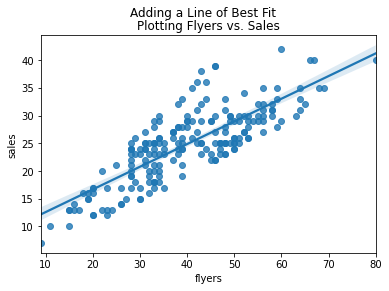

In [5]:
# Simple visualization (scatter plot)
plt.suptitle("Adding a Line of Best Fit")
plt.title("Plotting Flyers vs. Sales")

sns.regplot(x="flyers", y="sales", data=train)
plt.show()

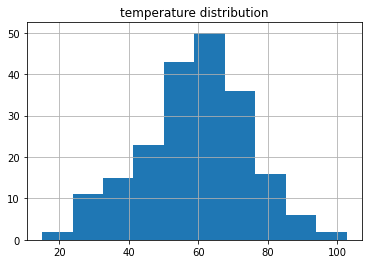

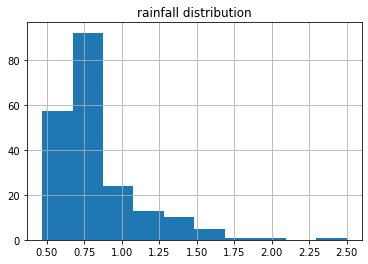

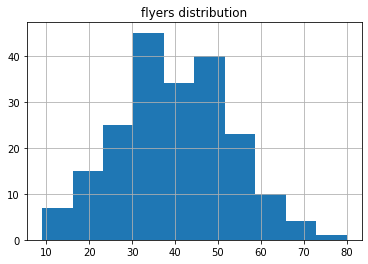

Text(0.5, 1.0, 'Log rainfall distribution')

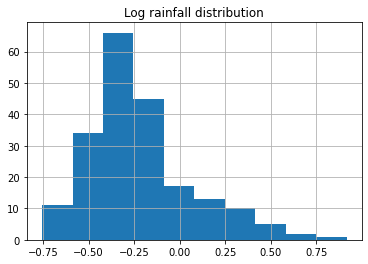

In [6]:
# Examine Distributions (hist)
train.temperature.hist()
plt.title('temperature distribution')
plt.show()
train.rainfall.hist()
plt.title('rainfall distribution')
plt.show()
train.flyers.hist()
plt.title('flyers distribution')
plt.show()
train.log_rainfall.hist()
plt.title('Log rainfall distribution')

***

**Takeaway:**
1. Temperature and Flyers are evently distributed
2. Rainfall is not evenly distributed
3. Log_Rainfall has a better distribution

***

# Flyers Model

### 2. Make a baseline for predicting sales. (The mean is a good baseline)

In [7]:
# Setting train to variable df
df = train

In [8]:
# Pre-requisite Part 1 - establish a baseline. 
# Since sales are reasonably normally distributed, the mean will do!
baseline = df.sales.mean()

In [9]:
# Pre-requisite Part 2 - build/identify a super simple linear model
# The arguments to the ols function are the column names as strings, separated by ~
# ols("y ~ x") 
model = ols('sales ~ flyers', df).fit()

### 3. Create a new dataframe to hold residuals.

In [10]:
# Pre-requisite Part 3 - Calculate residuals
evaluate = pd.DataFrame()

### 4. Calculate the baseline residuals. 

In [11]:
evaluate["x"] = df.flyers

# Our y is our dependent variable
evaluate["y"] = df.sales
evaluate["baseline"] = df.sales.mean()

# y-hat is shorthand for "predicted y" values
evaluate["yhat"] = model.predict()

# Calculate the baseline residuals 
evaluate["baseline_residual"] = evaluate.baseline - evaluate.y

# Calculate the model residuals
evaluate["model_residual"] = evaluate.yhat - evaluate.y

evaluate.head()

,x,y,baseline,yhat,baseline_residual,model_residual
224,54,29,24.789216,30.577489,-4.210784,1.577489
344,33,17,24.789216,21.982355,7.789216,4.982355
339,28,19,24.789216,19.935894,5.789216,0.935894
93,31,27,24.789216,21.163771,-2.210784,-5.836229
81,35,23,24.789216,22.800939,1.789216,-0.199061


***

**Takeaway:**
1. Based on the datafram it appears that our model_residual (distance between prediction and y)                      is less than baseline_residual (distance between baseline and y)

***

### 5. Evaulate Models Preformance
Does it Beat Baseline?

In [12]:
# Calculate if the model beats the baseline
baseline_sse = ((evaluate.baseline_residual**2).sum())
model_sse = ((evaluate.model_residual**2).sum())

if model_sse < baseline_sse:
    print("Our model beats the baseline")
    print("It makes sense to evaluate this model more deeply.")
else:
    print("Our baseline is better than the model.")

Our model beats the baseline
It makes sense to evaluate this model more deeply.


### 6. Create and fill and evaluation matrix
Evaluate distribution

In [13]:
metrics = pd.DataFrame()

# Sum the squares of the baseline errors
model_sse = ((evaluate.model_residual**2).sum())

# Take the average of the Sum of squared errors
# mse = model_sse / len(evaluate)

# Or we could calculate this using sklearn's mean_squared_error function
mse = mean_squared_error(evaluate.y, evaluate.yhat)

# Now we'll take the Square Root of the Sum of Errors
# Taking the square root is nice because the units of the error 
# will be in the same units as the target variable.
rmse = sqrt(mse)

print("SSE is", model_sse, " which is the sum sf squared errors")
print("MSE is", mse, " which is the average squared error")
print("RMSE is", rmse, " which is the square root of the MSE")

SSE is 3088.6078827503925  which is the sum sf squared errors
MSE is 15.140234719364669  which is the average squared error
RMSE is 3.8910454532637715  which is the square root of the MSE


### 7. Evaulating Models Significance
Calculating $R^2$ and $p$- value

In [14]:
# The model commented below is our model
# model = ols('sales ~ flyers', df).fit()

r2 = model.rsquared
print('R-squared = ', round(r2,3))

R-squared =  0.647


In [15]:
# F-Test for p value
f_pval = model.f_pvalue
print("p-value for model significance = ", f_pval)

f_pval < .05

p-value for model significance =  1.4309060748311366e-47


True



- Null hypothesis is that a model not built w/ the independent variables explains the relationship
- Alternative hypothesis is that our model built on independent varibles explains the relationship, validates that $R^2$

    - If p is less than 0.05, you're OK to conclude that your regression model fits the data better than the model with no independent variables, meaning the independent variables in your model improve the fit.
    - If greater than 0.05, it's probably better to stop using this set of features.
    - Basically, if the p is low, we can reject the null hypothesis.
    - And that means **we can accept the model as statistically significant**



### 8. Visualizing Residuals

In [16]:
# Visualizing Residuals
def plot_residuals(actual, predicted):
    residuals = actual - predicted
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title('Actual vs Residual')
    return plt.gca()

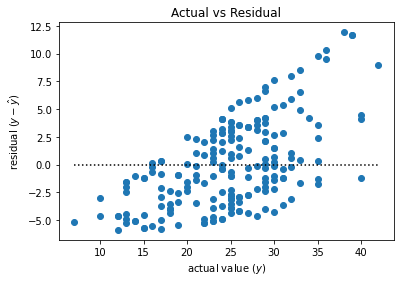

In [17]:
plot_residuals(evaluate.y, evaluate.yhat)

***

**Takeaway:**
1. Model is low residuals for low # of sales, as # of sales increases model is less effective

***

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 8751.936274509804
Model SSE 3088.6078827503925
SSE is 3088.6078827503925  which is the sum sf squared errors
MSE is 15.140234719364669  which is the average squared error
RMSE is 3.8910454532637715  which is the square root of the MSE
R-squared =  0.647
p-value for model significance =  1.4309060748311366e-47
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


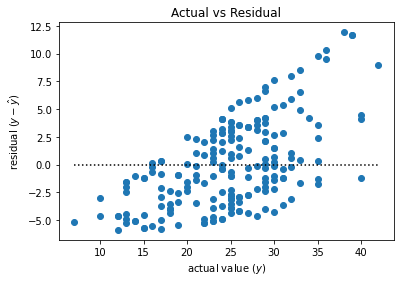

In [18]:
# Verification using function:

linear_model(ols('sales ~ flyers', train).fit(), train.sales, train.flyers)

# The Effects of Rainfall on Sales (Model 2)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 8751.936274509804
Model SSE 1574.6247854749695
SSE is 1574.6247854749695  which is the sum sf squared errors
MSE is 7.718748948406713  which is the average squared error
RMSE is 2.778263657107927  which is the square root of the MSE
R-squared =  0.82
p-value for model significance =  3.57848185220323e-77
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


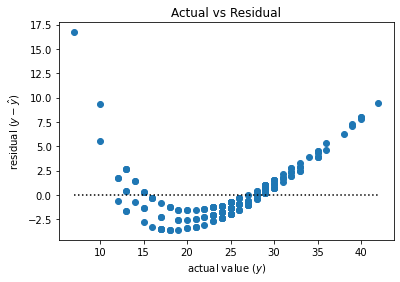

In [19]:
linear_model(ols('sales ~ rainfall', train).fit(), train.sales, train.rainfall)

***

**Takeaway:**
1. Model has a higher R-squared and lower p -value then Flyers
2. The Rainall model has a RMSE of 2.7, while Flyer Model is 3.9
3. **Rainfall Model is slightly better**

***

# The Effects of Log_Rainfall on Sales (Model 3)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 8751.936274509804
Model SSE 490.6647722626596
SSE is 490.6647722626596  which is the sum sf squared errors
MSE is 2.4052194718757822  which is the average squared error
RMSE is 1.5508770008855577  which is the square root of the MSE
R-squared =  0.944
p-value for model significance =  2.387168454557454e-128
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


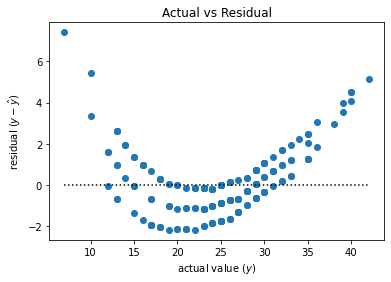

In [20]:
linear_model(ols('sales ~ log_rainfall', train).fit(), train.sales, train.log_rainfall)

***

**Takeaway:**
1. Model has a higher R-squared and lower p -value then Flyers and Rainfall
2. The Log_Rainall model has a RMSE of 1.6, while the rainfall model was 2.7, and the Flyer Model is 3.9
3. **Log_rainfall Model is better then both previous models**

***

# The Effects of Temperature on Sales (Model 4)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 8751.936274509804
Model SSE 183.26315503790406
SSE is 183.26315503790406  which is the sum sf squared errors
MSE is 0.898348799205412  which is the average squared error
RMSE is 0.9478126392939756  which is the square root of the MSE
R-squared =  0.979
p-value for model significance =  1.483709550672194e-171
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


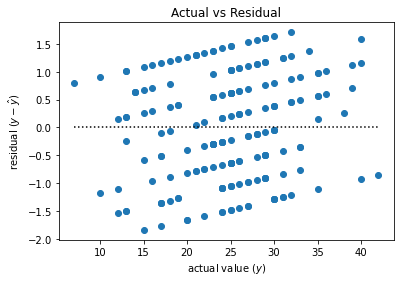

In [21]:
linear_model(ols('sales ~ temperature', train).fit(), train.sales, train.temperature)

***

**Takeaway:**
1. Model has a higher R-squared and lower p -value then Flyers, Rainfall, or Log_rainfall
2. The temp model has a RMSE of 0.95, while log_rainfall model was 1.6, rainfall model was 2.7, and the flyer model is 3.9
3. **Temp Model is the best Model**

***

<div class="alert alert-block alert-success"></div>

# Tips Dataset Exercises

Do you work for this exercise in either a jupyter notebook named evaluate within your regression-exercises repository. By the end of this exercise you will also create a python script named evaluate, so the overall deliverables for this exercise are the **python script** and **jupyter notebook** both with the name **evaluate** within your regression-exercises repo.

*****

### 1. Load the tips dataset from either pydataset or seaborn.

*****

In [22]:
df = sns.load_dataset("tips")
train_validate, test = train_test_split(df, test_size = .2, random_state = 123)
train, validate = train_test_split(train_validate, test_size = .3, random_state = 123)
train.shape, validate.shape, test.shape

((136, 7), (59, 7), (49, 7))

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 18 to 166
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  136 non-null    float64 
 1   tip         136 non-null    float64 
 2   sex         136 non-null    category
 3   smoker      136 non-null    category
 4   day         136 non-null    category
 5   time        136 non-null    category
 6   size        136 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 5.2 KB


In [24]:
train.describe()

,total_bill,tip,size
count,136.000000,136.000000,136.000000
mean,18.790515,2.946985,2.544118
std,8.779733,1.456611,0.987834
min,3.070000,1.000000,1.000000
25%,12.645000,2.000000,2.000000
50%,16.710000,2.680000,2.000000
75%,22.752500,3.500000,3.000000
max,48.330000,9.000000,6.000000


***

**Takeaway:**
1. Mean and Median are relatively close, so data is most likely evenly distributed

***

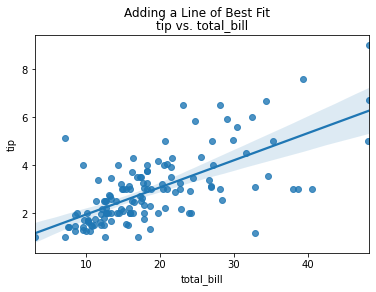

In [25]:
# simple visualization
plt.suptitle("Adding a Line of Best Fit")
plt.title('tip vs. total_bill')
sns.regplot(x="total_bill", y="tip", data=train)
plt.show()

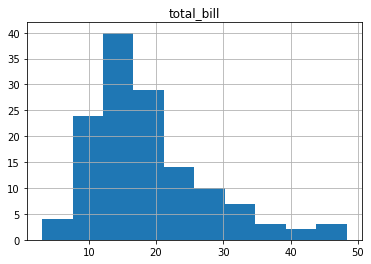

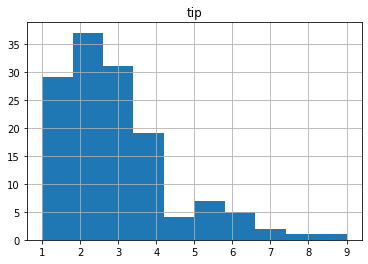

In [26]:
# Examine Distributions (hist) we want an approximately normal distribution
train.total_bill.hist()
plt.title('total_bill')
plt.show()
train.tip.hist()
plt.title('tip')
plt.show()

***

**Takeaway:**
1. total_bill appears to be evently distributed
2. tip does not appear to be evenly distributed

***

# The Effect of total_bill on tip (Model 1)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 286.43166397058826
Model SSE 153.53663973018627
SSE is 153.53663973018627  which is the sum sf squared errors
MSE is 1.1289458803690167  which is the average squared error
RMSE is 1.0625186494217487  which is the square root of the MSE
R-squared =  0.464
p-value for model significance =  7.18647033208955e-20
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


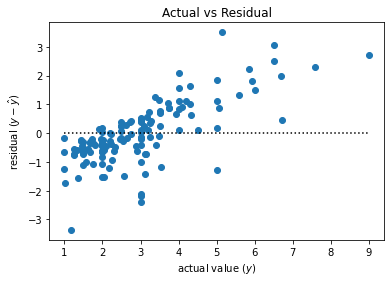

In [27]:
linear_model(ols('tip ~ total_bill', train).fit(), train.tip, train.total_bill)

***

**Takeaway:**
1. Model has a low R-squared value, but a low p -value
2. The total_bill model has a RMSE of 1
3. Model does a good job approximating tip up to $4

***

In [28]:
linear_model(ols('size ~ total_bill', train).fit(), train.size, train.total_bill)

Our baseline is better than the model.


In [29]:
linear_model(ols('size ~ tip', train).fit(), train.size, train.tip)

Our baseline is better than the model.


Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 10406.301463970589
Model SSE 5578.114293123068
SSE is 5578.114293123068  which is the sum sf squared errors
MSE is 41.01554627296373  which is the average squared error
RMSE is 6.4043380823441645  which is the square root of the MSE
R-squared =  0.464
p-value for model significance =  7.186470332089448e-20
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


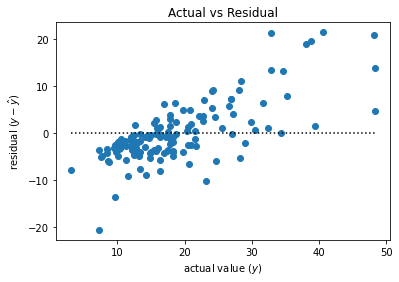

In [30]:
linear_model(ols('total_bill ~ tip', train).fit(), train.total_bill, train.tip)

# MPG Dataset

- Load the mpg dataset and fit a model that predicts highway mileage based on engine displacement. Take a look at all the regression evaluation metrics, and determine whether this model is better than the baseline model. Use the functions from your evaluate.py to help accomplish this.

In [31]:
df = data('mpg')
train_validate, test = train_test_split(df, test_size = .2, random_state = 123)
train, validate = train_test_split(train_validate, test_size = .3, random_state = 123)
train.shape, validate.shape, test.shape

((130, 11), (57, 11), (47, 11))

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 229 to 13
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  130 non-null    object 
 1   model         130 non-null    object 
 2   displ         130 non-null    float64
 3   year          130 non-null    int64  
 4   cyl           130 non-null    int64  
 5   trans         130 non-null    object 
 6   drv           130 non-null    object 
 7   cty           130 non-null    int64  
 8   hwy           130 non-null    int64  
 9   fl            130 non-null    object 
 10  class         130 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 12.2+ KB


In [33]:
train.head()

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
229,volkswagen,passat,1.8,1999,4,auto(l5),f,18,29,p,midsize
56,dodge,dakota pickup 4wd,5.2,1999,8,manual(m5),4,11,17,r,pickup
145,nissan,altima,2.5,2008,4,manual(m6),f,23,32,r,midsize
222,volkswagen,new beetle,1.9,1999,4,manual(m5),f,35,44,d,subcompact
232,volkswagen,passat,2.8,1999,6,auto(l5),f,16,26,p,midsize


In [34]:
train.describe()

,displ,year,cyl,cty,hwy
count,130.000000,130.000000,130.000000,130.000000,130.000000
mean,3.420769,2003.707692,5.838462,16.892308,23.630769
std,1.315011,4.512594,1.664978,4.374426,6.068266
min,1.600000,1999.000000,4.000000,9.000000,12.000000
25%,2.400000,1999.000000,4.000000,13.250000,18.000000
50%,3.100000,2008.000000,6.000000,17.000000,25.000000
75%,4.600000,2008.000000,8.000000,19.000000,27.000000
max,6.200000,2008.000000,8.000000,35.000000,44.000000


***

**Takeaway:**
1. Mean and Median are relatively close on hwy and displacement(likely even distrubtion)

***

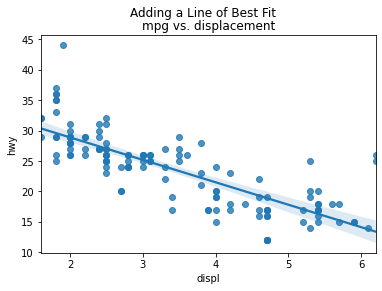

In [35]:
# Quick visualization of sample data (highway_mieage and engine_displacement)
plt.suptitle("Adding a Line of Best Fit")
plt.title('mpg vs. displacement')
sns.regplot(x="displ", y="hwy", data=train)
plt.show()

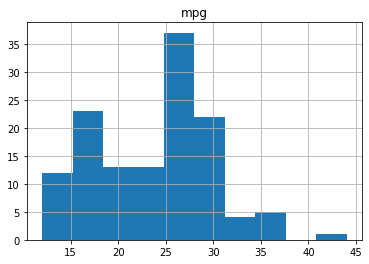

In [36]:
# Examine Distributions (hist) we want an approximately normal distribution
train.hwy.hist()
plt.title('mpg')
plt.show()

***

**Takeaway:**
1. hwy appears to be evenly distributed

***

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 4750.276923076923
Model SSE 1722.7590136557005
SSE is 1722.7590136557005  which is the sum sf squared errors
MSE is 13.251992412736158  which is the average squared error
RMSE is 3.6403286132897614  which is the square root of the MSE
R-squared =  0.637
p-value for model significance =  5.6465159654260946e-30
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


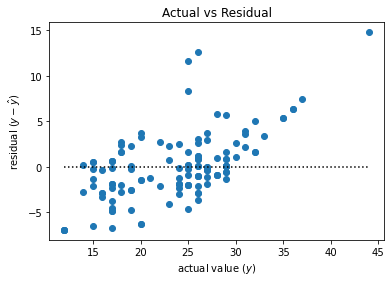

In [37]:
# model the predicts mpg(target/dependent) based on displacement(independent)
# def linear_model(linear_model, target, feature)
#               (target~feature)

linear_model(ols('hwy ~ displ', train).fit(), train.hwy, train.displ)

***

**Takeaway:**
1. The model has a RMSE of 61 (the model is off by approximatly 61 mpg)
2. The model has an R-squared value of 0.654 (Strenght of relationship between model and independent variable)
3. R-square value validated by F-Test p-value, reject null, indipendent variable explains relationship
4. Model exhibis a lot a lot of error in both directions
***

# Exercise w/Scaled Data

In [43]:
train, validate, test = wrangle_telco(True)
train.head()

,customer_id,monthly_charges,tenure,total_charges,total_charges_scaled,monthly_charges_scaled,tenure_scaled
1256,7501-IWUNG,73.80,61,4616.05,0.532410,0.552618,0.847222
225,1303-SRDOK,69.05,55,3842.60,0.443201,0.505237,0.763889
662,3967-VQOGC,24.90,67,1680.25,0.193798,0.064838,0.930556
628,3777-XROBG,19.55,58,1079.65,0.124526,0.011471,0.805556
824,5075-JSDKI,24.45,59,1493.10,0.172213,0.060349,0.819444


Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 319361.22866174916
Model SSE 184315.27503105695
SSE is 184315.27503105695  which is the sum sf squared errors
MSE is 194.22052163441197  which is the average squared error
RMSE is 13.936302294167271  which is the square root of the MSE
R-squared =  0.423
p-value for model significance =  3.6779031703406977e-115
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


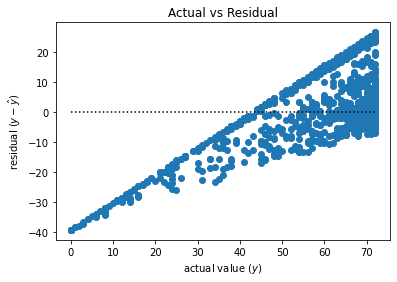

In [44]:
# Predict tenure with total_charges

linear_model(ols('tenure ~ total_charges', train).fit(), train.tenure, train.total_charges)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 61.60517528197323
Model SSE 35.554644103213136
SSE is 35.554644103213136  which is the sum sf squared errors
MSE is 0.03746537840169983  which is the average squared error
RMSE is 0.1935597540856565  which is the square root of the MSE
R-squared =  0.423
p-value for model significance =  3.6779031703398614e-115
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


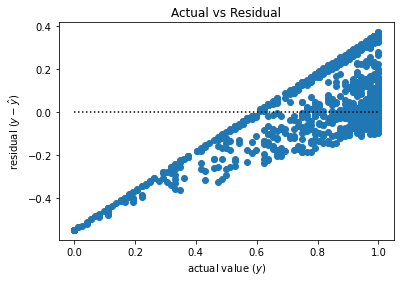

In [45]:
# Predict tenure with total_charges_scaled

linear_model(ols('tenure_scaled ~ total_charges_scaled', train).fit(), train.tenure_scaled, train.total_charges_scaled)